Importanto bibliotecas

In [2]:
#-*- coding: utf-8 -*-

import os        # permite que os scripts e notebooks se comuniquem com o sistema operacional 
import json      # permite que os scripts e notebooks leiam e escrevam arquivos .json
import unidecode # permite que os scripts e notebooks lidem com caracteres especiais
import datetime  # permite que os scripts e notebooks lidem com variáveis de data e hora 
import pickle    # permite que os scripts e notebooks salvem e leiam variaveis em arquivos pickle

import matplotlib                        # biblioteca para produzir graficos
import matplotlib.pyplot as plt          # metodo para produzir graficos
from scipy.interpolate import griddata   # funcao para lidar com dados xyz
import seaborn as sns                    # biblioteca para produzir graficos bonitos
import numpy as np                       # biblioteca para operacoes matematicas
import pandas as pd                      # biblioteca para operacoes com tabelas
import geopandas                         # biblioteca para operacoes com mapas
import folium                            # biblioteca para operacoes com mapas
import cartopy                           # biblioteca para operacoes com mapas
import cartopy.crs as ccrs               # metodo para operacoes com mapas
import xarray as xr                      # biblioteca para lidar com arquivos nc

# metodos auxiliares nos graficos de mapas 
from cartopy.mpl.ticker import LongitudeFormatter, \
                               LatitudeFormatter

# metodos auxiliares na visualizacao de tabelas 
from IPython.display import IFrame, \
                            display

# mostra os graficos no notebook
%matplotlib inline

# define 9x6 como default para dimensoes de graficos
plt.rcParams["figure.figsize"] = (9,6)

# Dados

In [3]:
# criando tabela com os dados
df = pd.DataFrame()

for i in range(18):
    df = df.append(pd.read_csv('../../../Dropbox-heavy-stuff/csv/FINAL_{}.csv'.format(i), dtype='object'), ignore_index=True)

In [4]:
# dimensoes da tabela
df.shape

(623780, 26)

- - -

In [5]:
# primeiras linhas da tabela
df.head()

,Unnamed: 0,VARIABLES,Depth,uncertain,F,O,Temperatur,uncertain.1,F.1,O.1,...,ID,LAT,LON,YEAR,MONTH,DAY,depth_u,temp_u,salt_u,press_u
0,0,1,0.0,0.00,0,,16.1,0.0,0,,...,11734766,45.550,32.0500,1890,6,27,m,degreesC,PSS,dbar
1,1,2,24.8,1.24,0,,16.2,0.0,0,,...,11734766,45.550,32.0500,1890,6,27,m,degreesC,PSS,dbar
2,2,3,49.6,2.48,0,,16.1,0.0,0,,...,11734766,45.550,32.0500,1890,6,27,m,degreesC,PSS,dbar
3,3,4,99.3,4.96,0,,16.4,0.0,0,,...,11734766,45.550,32.0500,1890,6,27,m,degreesC,PSS,dbar
4,4,5,198.5,9.93,0,,15.2,0.0,0,,...,11734766,45.550,32.0500,1890,6,27,m,degreesC,PSS,dbar


In [6]:
# checando se as principais variaveis estao com as mesmas unidades
display(df['depth_u'].unique())
display(df['temp_u'].unique())
display(df['salt_u'].unique())
display(df['press_u'].unique())

array(['m'], dtype=object)

array(['degreesC'], dtype=object)

array(['PSS'], dtype=object)

array(['dbar'], dtype=object)

In [7]:
# variaveis da tabela
df.dtypes

Unnamed: 0     object
VARIABLES      object
Depth          object
uncertain      object
F              object
O              object
Temperatur     object
uncertain.1    object
F.1            object
O.1            object
Salinity       object
uncertain.2    object
F.2            object
O.2            object
Pressure       object
uncertain.3    object
ID             object
LAT            object
LON            object
YEAR           object
MONTH          object
DAY            object
depth_u        object
temp_u         object
salt_u         object
press_u        object
dtype: object

In [8]:
# convertendo variaveis numericas em numero
for v in ['Depth', 'Temperatur', 'Salinity', 'Pressure', 'LAT', 'LON']:
    df[v] = df[v].astype(float)

for v in ['YEAR', 'MONTH', 'DAY']:
    df[v] = df[v].astype(int)

# variaveis da tabela
df.dtypes

Unnamed: 0      object
VARIABLES       object
Depth          float64
uncertain       object
F               object
O               object
Temperatur     float64
uncertain.1     object
F.1             object
O.1             object
Salinity       float64
uncertain.2     object
F.2             object
O.2             object
Pressure       float64
uncertain.3     object
ID              object
LAT            float64
LON            float64
YEAR             int64
MONTH            int64
DAY              int64
depth_u         object
temp_u          object
salt_u          object
press_u         object
dtype: object

## Visão geral

### Histórico

count    623780.000000
mean       1987.526902
std          13.743554
min        1890.000000
25%        1981.000000
50%        1989.000000
75%        1996.000000
max        2016.000000
Name: YEAR, dtype: float64

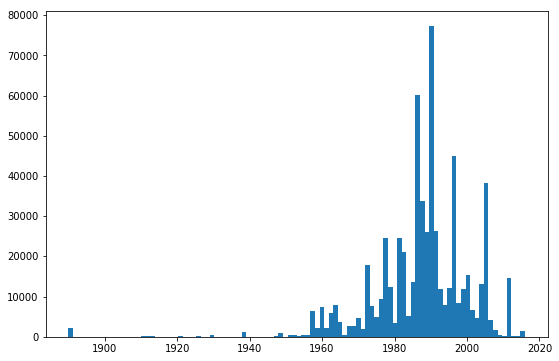

In [16]:
display(df['YEAR'].describe())

p = df['YEAR'].hist(bins=100, grid=False);
fig = p.get_figure();
fig.savefig('img_year.png', dpi=100);

### Variáveis de interesse

#### Profundidade

count    623780.000000
mean        265.780075
std         455.933914
min          -0.200000
25%          29.700000
50%          94.200000
75%         297.400000
max        6362.370000
Name: Depth, dtype: float64

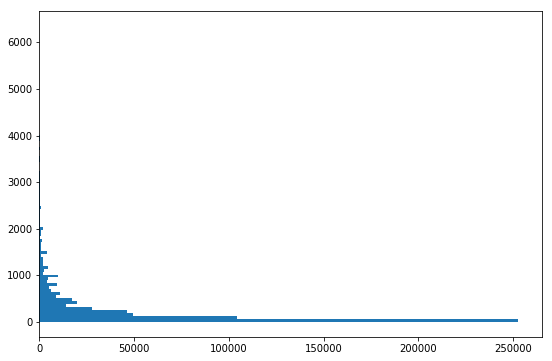

In [17]:
display(df['Depth'].describe())

p = df['Depth'].hist(bins=100, orientation="horizontal", grid=False)
fig = p.get_figure();
fig.savefig('img_depth.png', dpi=100);

#### Temperatura

count    620700.000000
mean         10.193265
std           7.136283
min         -11.600000
25%           5.194375
50%           8.840000
75%          14.290000
max          70.290000
Name: Temperatur, dtype: float64

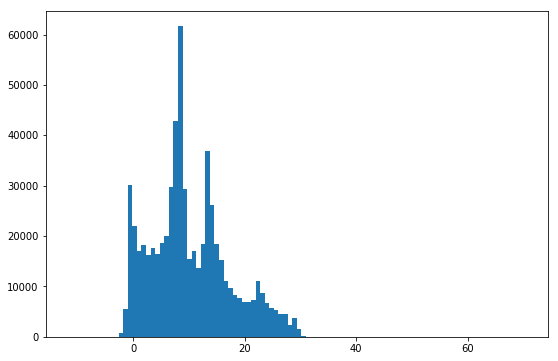

In [18]:
display(df['Temperatur'].describe())

p = df['Temperatur'].hist(bins=100, grid=False)
fig = p.get_figure();
fig.savefig('img_temperature.png', dpi=100);

#### Coordenadas das medidas

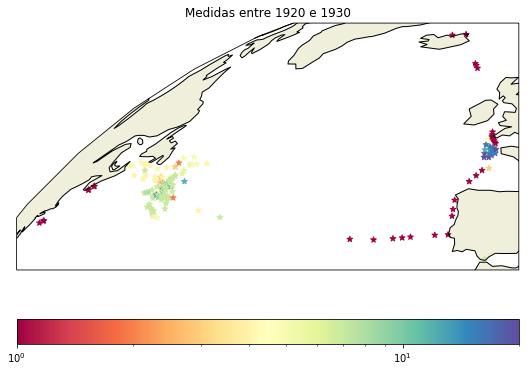

In [17]:
MINLON = -80
MAXLON = 10
MINLAT = 0
MAXLAT = 70
START  = 1920
END    = 1930

_mask    = (
            (df['LON'].between(MINLON, MAXLON, inclusive=True)) &\
            (df['LAT'].between(MINLAT, MAXLAT, inclusive=True)) &\
            (df['YEAR'].between(START, END, inclusive=True))     \
           ).copy()
_group   = df[ _mask ].groupby(by=['LON', 'LAT']).count().copy()
x, y     = zip( *_group.index.tolist() )
count    = _group['VARIABLES'].values.tolist()

X,Y    = np.mgrid[MINLON:MAXLON, MINLAT:MAXLAT]
P      = [[a,b] for a,b in zip(x,y)]
gcount = griddata(P, count, (X, Y), method='linear')

ax = plt.axes(projection=ccrs.Orthographic())
#ax.set_global()
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)

#normalize = matplotlib.colors.PowerNorm(vmin=min(count), vmax=max(count), gamma=1/6)
normalize = matplotlib.colors.LogNorm(vmin=min(count), vmax=max(count))
#c = ax.contour(X, Y, gcount, 10, linewidths=0.5, colors='k')
#p = ax.contourf(X, Y, gcount, 25)
s = ax.scatter(x,y,c=count, norm=normalize, cmap=plt.cm.Spectral, marker='*', transform=ccrs.Geodetic())

#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
#ax.set_xticks(np.linspace(MINLON, MAXLON, 5), crs=ccrs.PlateCarree())
#ax.set_yticks(np.linspace(MINLAT, MAXLAT, 5), crs=ccrs.PlateCarree())
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)
#ax.set_ylim((MINLON, MAXLON))
#ax.set_ylim((MINLAT, MAXLAT))

plt.title('Medidas entre {} e {}'.format(START, END))
plt.colorbar(s, orientation='horizontal', fraction=0.09)
plt.savefig('img_01.png', dpi=100)
plt.show()

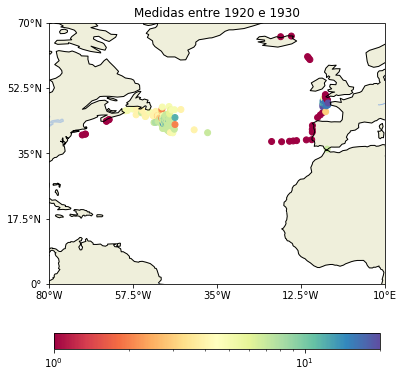

In [16]:
MINLON = -80
MAXLON = 10
MINLAT = 0
MAXLAT = 70
START  = 1920
END    = 1930

_mask    = (
            (df['LON'].between(MINLON, MAXLON, inclusive=True)) &\
            (df['LAT'].between(MINLAT, MAXLAT, inclusive=True)) &\
            (df['YEAR'].between(START, END, inclusive=True))     \
           ).copy()
_group   = df[ _mask ].groupby(by=['LON', 'LAT']).count().copy()
x, y     = zip( *_group.index.tolist() )
count    = _group['VARIABLES'].values.tolist()

X,Y    = np.mgrid[MINLON:MAXLON, MINLAT:MAXLAT]
P      = [[a,b] for a,b in zip(x,y)]
gcount = griddata(P, count, (X, Y), method='linear')

ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)

#normalize = matplotlib.colors.PowerNorm(vmin=min(count), vmax=max(count), gamma=1/6)
normalize = matplotlib.colors.LogNorm(vmin=min(count), vmax=max(count))
#c = ax.contour(X, Y, gcount, 10, linewidths=0.5, colors='k')
#p = ax.contourf(X, Y, gcount, 25)
s = ax.scatter(x,y,c=count, norm=normalize, cmap=plt.cm.Spectral, marker='o', transform=ccrs.Geodetic())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.set_xticks(np.linspace(MINLON, MAXLON, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(MINLAT, MAXLAT, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim((MINLON, MAXLON))
ax.set_ylim((MINLAT, MAXLAT))

plt.title('Medidas entre {} e {}'.format(START, END))
plt.colorbar(s, orientation='horizontal', fraction=0.05)
plt.savefig('img_02.png', dpi=100)
plt.show()

- - -